### Linear combination of unitaries. ( pauli operators )

LCU logic

In [97]:
import pennylane as qml 
import numpy as np 

aux = 1
main = 1
total = aux + main 

awires = range(aux)
mwires = range(aux, aux+main)

dev = qml.device('default.qubit', wires=total)

def prepare_state(state):
    qml.MottonenStatePreparation(state, wires=mwires)

@qml.qnode(dev)
def lcu(coeffs, Ulist, state):
    prepare_state(state)
    qml.Hadamard(0)
    for i in range(2**aux):
        control_values = [int(i) for i in np.binary_repr(i, aux)]
        qml.ControlledQubitUnitary(Ulist[i], control_wires=[0], wires=1, control_values=control_values)
    qml.Hadamard(0)
    return qml.state()


$ X + Z $

state |0> =  [0.5+0.j 0.5+0.j]
state |1> =  [ 0.5+0.j -0.5+0.j]


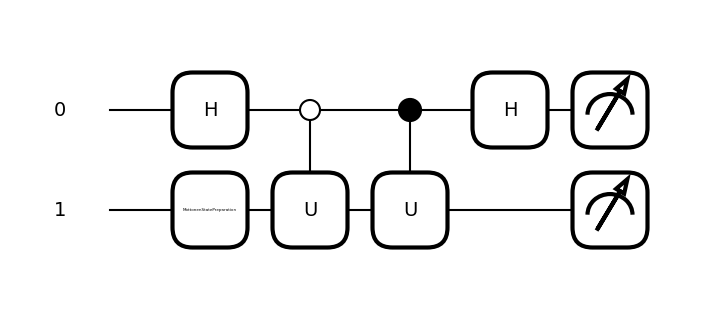

In [98]:
Ulist = [
    qml.PauliZ.compute_matrix(),     
    qml.PauliX.compute_matrix(), 
]

qml.draw_mpl(lcu)([], Ulist, [1,0])

z = qml.QNode(lcu, dev)([], Ulist, [1,0])[:2]
print ('state |0> = ', np.round(z, 2))
z = qml.QNode(lcu, dev)([], Ulist, [0,1])[:2]
print ('state |1> = ', np.round(z, 2))

$ RZ(pi/2) + RZ (-pi/2) $

state |0> =  [0.71+0.j 0.  +0.j]
state |1> =  [0.  +0.j 0.71+0.j]


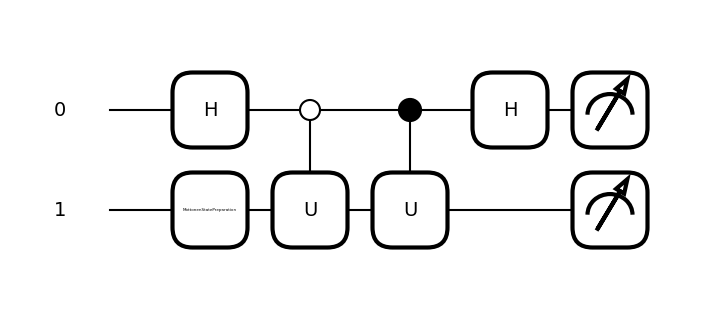

In [99]:
Ulist = [
    qml.RZ.compute_matrix(np.pi/2),     
    qml.RZ.compute_matrix(-np.pi/2), 
]

qml.draw_mpl(lcu)([], Ulist, [1,0])

z = qml.QNode(lcu, dev)([], Ulist, [1,0])[:2]
print ('state |0> = ', np.round(z, 2))
z = qml.QNode(lcu, dev)([], Ulist, [0,1])[:2]
print ('state |1> = ', np.round(z, 2))

### Implement unitary for the following. 

$ H \otimes X + H \otimes Z $
$ = (X + Z) \otimes X + (X + Z) \otimes Z = X \otimes X + Z \otimes Z + X \otimes Z + Z \otimes X $

The amplitudes on the main register are proportional to [ 0.25+0.j -0.25+0.j  0.25+0.j -0.25+0.j] .


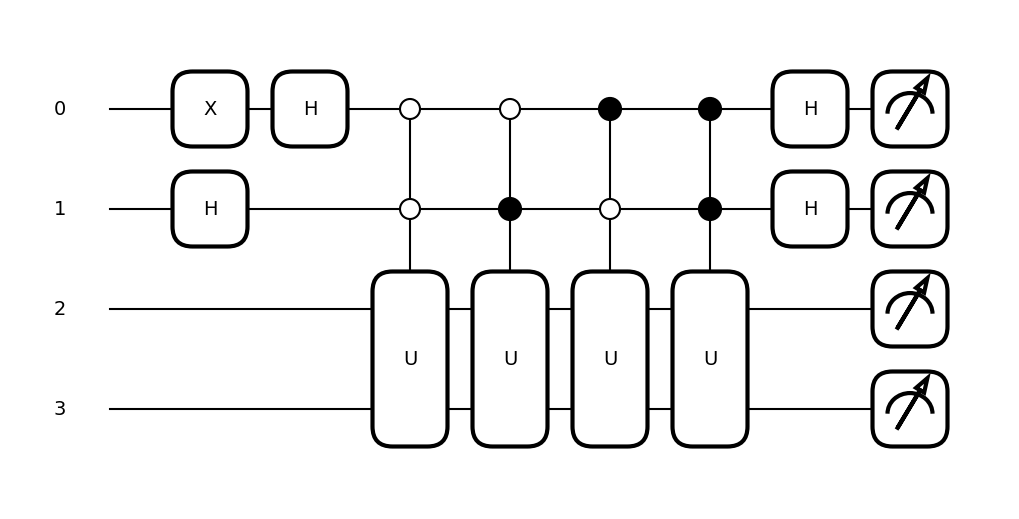

In [100]:
k_bits = 2
n_bits = 2
all_bits = k_bits + n_bits
aux = range(k_bits)
main = range(k_bits, all_bits)
dev = qml.device("default.qubit", wires=all_bits)

def SELECT_uniform(U_list):
    for index in range(2**k_bits):
        ctrl_str =  [int(i) for i in np.binary_repr(index, k_bits)]
        qml.ControlledQubitUnitary(U_list[index], control_wires=aux, wires=main, control_values=ctrl_str)

@qml.qnode(dev)
def XH_plus_HZ():  
    U_list = [
        np.kron(qml.PauliX.compute_matrix(), qml.PauliX.compute_matrix()),
        np.kron(qml.PauliZ.compute_matrix(), qml.PauliX.compute_matrix()),
        np.kron(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix()),
        np.kron(qml.PauliZ.compute_matrix(), qml.PauliZ.compute_matrix()),
    ]
    
    qml.PauliX(0)
    
    for i in aux:
        qml.Hadamard(i)
    
    SELECT_uniform(U_list[::-1])
    
    for i in aux:
        qml.Hadamard(i)    
    
    return qml.state()

qml.draw_mpl(XH_plus_HZ)()

print("The amplitudes on the main register are proportional to", XH_plus_HZ()[:4], ".")


$ H \otimes (X+Z/2) = (X + Z) \otimes (X + Z/2) = X \otimes X + 1/2 (X \otimes Z) + 1/2 (X \otimes Z) + (Z \otimes X)$

The amplitudes on the main register are proportional to [0.33626291 0.10010848 0.10010848 0.14106318] .


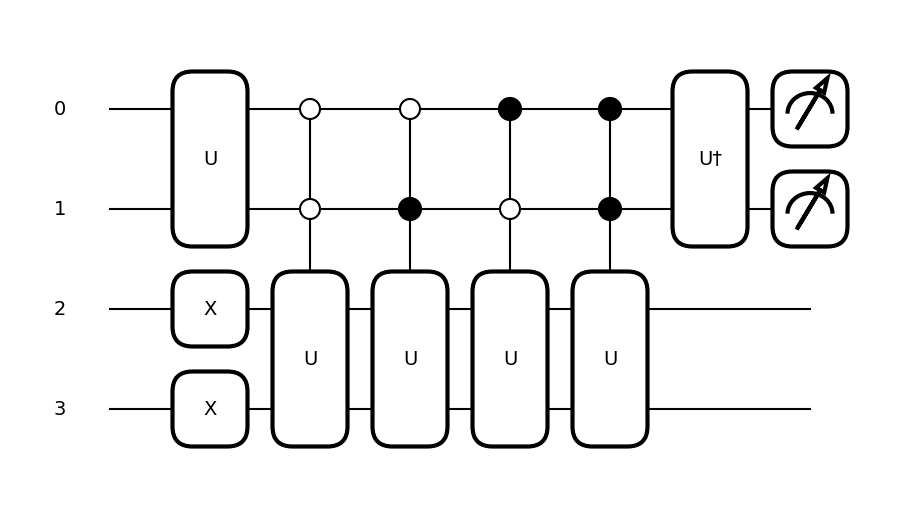

In [102]:
k_bits = 2
n_bits = 2
all_bits = k_bits + n_bits
aux = range(k_bits)
main = range(k_bits, all_bits)
dev = qml.device("default.qubit", wires=all_bits)

def householder(state):
    o = 2 * np.outer(state, state)
    return np.eye(o.shape[0]) - o

def PREPARE(alpha_list):
    zero_vec = np.array([1] + [0]*(2**k_bits - 1))
    alpha_list = alpha_list/np.linalg.norm(alpha_list)
    return householder(zero_vec - alpha_list)

U_list = [np.kron(qml.PauliX.compute_matrix(), qml.PauliX.compute_matrix()),
          np.kron(qml.PauliZ.compute_matrix(), qml.PauliZ.compute_matrix()),
          np.kron(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix()),
          np.kron(qml.PauliZ.compute_matrix(), qml.PauliX.compute_matrix())]

alpha_list = [1, 0.5, 0.5, 1]

def SELECT(U_list):
    for index in range(2**k_bits):
        ctrl_str =  [int(i) for i in np.binary_repr(index, k_bits)]
        qml.ControlledQubitUnitary(U_list[index], control_wires=aux, 
                                   wires=main, control_values=ctrl_str)

def LCU(alpha_list, U_list):    
    qml.QubitUnitary(PREPARE(alpha_list), wires=aux, id="alpha")
    SELECT(U_list)
    qml.adjoint(qml.QubitUnitary(PREPARE(alpha_list), wires=aux))

@qml.qnode(dev)
def my_circuit():
    qml.PauliX(wires=2)
    qml.PauliX(wires=3)
    LCU(alpha_list, U_list)
    return qml.probs([0,1])

qml.draw_mpl(my_circuit)()

print("The amplitudes on the main register are proportional to", my_circuit()[:4], ".")
